# Visualizing the calibration code
For more details of the calibration reasoning, see the pdf in the root file.
## Summary
Here we not only define the calibration code, we also have made some visualizations to show where the code is searching and assuming the "center" of the brightest particle detected is.
- First we detect the birghtest particle
- Then we check which subsection it is in
- After we get the proper calibration offsets for that subsections
- Finally we plot the visual, remove the data detected in those areas, and repeat

In [14]:
# Importing libraires and defining model for fitting
import os
import ccd_helpers
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from skimage import morphology as morph
import lmfit
import math
from lmfit.models import GaussianModel
from lmfit.lineshapes import gaussian
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
from PIL import Image, ImageOps
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion

## Functions to help

In [15]:
#Function to get and store the parameters of peaks
def get_2D_list(z_grid_blur, x_grid, y_grid):
    """
        Takes the image data after applying gaussian blur

    Args:    
        z_grid_blur[numpy 2D arry]: Numpy array generated after passing it through gaussian blur
        x_grid[numpy 2D arry]: Grid generated from np.linspace in the shape of the img data grid(z_grid)
        y_grid[numpy 2D arry]: Grid generated from np.linspace in the shape of the img data grid(z_grid)
    Returns:
        numpy 2D array in the form of [a, x, y] where a is the intensity of the detected peak
    """
    # Saves the values of the peaks in a 2D array in the format
    # a, cx, cy
    peak_param = []
    for i in range(len(z_grid_blur)):
        for j in range(len(z_grid_blur)):
            # If location i j is True
            if z_grid_blur[i][j]:
                peak_param.append([z_grid_blur[i][j], x_grid[i][j], y_grid[i][j]])
    return np.array(peak_param)

In [16]:
def find_strongest_dude(peak_2D):
    """
        Takes the results of get_2D_list, finds the strongest a value (intensity) and returns its x and y location

    Args:    
        peak_2D[numpy 2D arry]: Numpy array generated from get_peak_2D

    Returns:
        tuple of the x and y values of hte strongest detected peak
    """
    strongest = 0
    for i in range(len(peak_2D)):
        if peak_2D[i][0] > strongest:
            strongest = peak_2D[i][0]
            # need to find the x and y location
            Cx = peak_2D[i][1]
            Cy = peak_2D[i][2]
    
    return[Cx, Cy]

In [17]:

def remv_near_peaks(z_peaks, rsearch):
    """
        Takes the results of get_2D_list and removes any particles within the rsearch threshold including itself

    Args:    
        z_peaks[numpy 2D arry]: Numpy array generated from get_2D_lists function
        rsearch[float]: The eucledian distance threshold that would be considered the "same" particle

    Returns:
        numpy 2D array of the particles after removing the nearest to the strongest dude
    """
    
    # The x and y values of the strongest peaks
    Cx, Cy = find_strongest_dude(z_peaks)
    
    
    # Iterate over the length of the peaks
    # here we use the get_peak_2D function which returns the detected peaks
    # in a 2D array of [a, x, y]
    for i in range(len(z_peaks)):
        
        # Coordinates of peak point
        Qx = z_peaks[i][1]
        Qy = z_peaks[i][2]

        # diatance between strongest peak and the rest of the peaks
        dist = math.dist([Cx, Cy], [Qx, Qy])

        # If in range, make the z_peaks value 0, include strongest yet found
        if dist < rsearch: #and [Qx, Qy] != [Cx, Cy]:
            z_peaks[i][0] = 0
       
    return z_peaks

# Function to get offsets

In [18]:
def get_offsets(z_grid_blur):
    
    """
        Takes the z_grid data of the image (blurred as per instructions) of the Calibrations
        folder and returns the offsets. NOTE - The file MUST BE the calibrated image folder
        in order to get the proper offsets

    Args:    
        z_grid_blur[numpy 2D arry]: The image data(as a numpy 2D array) 
        from the Calibrations folder
        
    Returns:
        A dict of the calibrations in the form {"Segment(num):" [offset x, offset y]}, where(num)
        is the Segment number that corresponds to where the strongest peak was found
    """
    
    # New selection of each segment
    new_selection = [ [-0.837, -0.279, 0.000, 0.558],
                      [-0.279, 0.279, 0.000, 0.558],
                      [0.279, 0.837, 0.000, 0.558],
                      [0.279, 0.837, -0.558, 0.000],
                      [-0.279, 0.279, -0.558, 0.000],
                      [-0.837, -0.279, -0.558, 0.000] ]
    
    # Initilize dict to store values
    calib_dict = {}
    # The centers as defiend by the pdf
    centers = [ [-0.558, 0.279],
                [0.000, 0.279],
                [0.558, 0.279],
                [0.559, -0.279],
                [0.000, -0.279],
                [-0.559, -0.279] ]
    
    
    # Get the dimensions of the image; used to create the x and y values
    dimensions = z_grid_blur.shape 

    # With the length of the second dimension, create - 1 ~ 1 with dimensions[1] value 
    x = np.linspace(-1, 1, dimensions[1])

    # With the length of the first dimension, create - 1 ~ 1 with dimensions[0] value
    y = np.linspace(1, -1, dimensions[0])

    # create meshgrid as before
    x_grid, y_grid = np.meshgrid(x, y) 

    # storet the "peaks" in [a, x, y] form after blurring
    z_peaks = get_2D_list(z_grid_blur, x_grid, y_grid)
    
    # loop over the number of segments
    for i in range(6):
        # Store the x and y values of strongest peak
        Cx, Cy = find_strongest_dude(z_peaks)
        #loop over the defined centers of each segment
        for j in range(len(centers)):
            # Store the min and max values for x and y
            xmin = new_selection[j][0]
            xmax = new_selection[j][1]
            ymin = new_selection[j][2]
            ymax = new_selection[j][3]

            # Check which segment the strongest guy belongs to
            if Cx > xmin and Cx < xmax and Cy > ymin and Cy < ymax:
                # Store the offsets
                offsetX = Cx - centers[j][0] 
                offsetY = Cy - centers[j][1] 
                
                # Save the offsets and the segment they are in
                calib_dict["Segment:" + str(j)] = [offsetX, offsetY]
                
        # Remove the strongest and everthing within  of him
        #### rmv_near peaks must be 0.25!!
        z_peaks = remv_near_peaks(z_peaks, 0.25)
            
    return calib_dict

# Get the calibrations by file and segment
## Order is as follows
- 001.tiff Segment 0
- 003.tiff Segment 1
- 005.tiff Segment 2
- 007.tiff Segment 3
- 009.tiff Segment 4
- 011.tiff Segment 5

Where each "Segment" is the section of the image that is focused in the center.

# Each index in Calib corresoponds to the image/Segment being calibrates

In [19]:
def get_Calibs(file_name):
       
    """
        Takes the file name of the Calibrations folder and returns an array of Calib dicts. Each
        index of that array corresponds the segment the strongest peak was found. Example:
        we need the offsets for when the strongest peak in the image is found in Segment 0,
        then we would need Calib[0] and from there we access the offset based on the segment we are
        searching in the current file.

    Args:    
        file_name[string]: The file that contains ONLY the 6 calibration images
        
    Returns:
        A 1D array of Calibration dicts
    """
    
    # Parameters for blurring
    sigma = 2 # For gaussian blur
    connectivity = 2 # for detect peaks connectivity
    
    # array to store Calib dicts
    Calib = []
    
    # Make a new loop, looping through all 6 calibration files
    files = ccd_helpers.get_img_files(file_name)
    for file in files:
        
        # get the image
        img = Image.open(file_name + '/' + file)
        # get the z data
        z_grid = np.array(img).astype('float')

        # blur the peaks
        z_grid_blur = gaussian_filter(z_grid, sigma)
        
        # append dict to Calib
        Calib.append(get_offsets(z_grid_blur))
        
    return Calib

# Task 2, applying offsets to save peaks that are likely the same particle

## Functions to help

In [20]:
def find_segment(X, Y):
    """
        Takes the X and Y values (NOT index) of the image data (either x_grid/y_grid, strongest peak etc)
        and returns which segment that value is in.
        
        NOTE - needs to be modified in cases where the incoming values are outside of the selection

    Args:    
        X, Y[float]: The x and y coordinate values ( betwenn -1 ~ 1 usually)
        
    Returns:
        An integer value representing the segment located
    """
    
    
    # Borders of image data
    new_selection = [ [-0.837, -0.279, 0.000, 0.558],
                      [-0.279, 0.279, 0.000, 0.558],
                      [0.279, 0.837, 0.000, 0.558],
                      [0.279, 0.837, -0.558, 0.000],
                      [-0.279, 0.279, -0.558, 0.000],
                      [-0.837, -0.279, -0.558, 0.000] ]

    
    # iterate over the selections
    for i in range(len(new_selection)):
        xmin = new_selection[i][0]
        xmax = new_selection[i][1]
        ymin = new_selection[i][2]
        ymax = new_selection[i][3]

        # If the x and y coordinate fall within the range, return the segment location
        if X > xmin and X < xmax and Y > ymin and Y < ymax:
            return(i)
        


In [21]:
def psearch(peaks, radius):
    
    """
        Takes the peaks values as a 2D numpy array, and a radius, and searches for any values
        within that radius and returns another array with the found particles
        
    Args:    
        peaks[numpy 2D array]: Array of arrays representing the peaks in the form of [intensity, x, y]
        radius[float]: The radius to search
        
    Returns:
        A 2D array of the peaks that were within the specifed radius
    """
    
    # The segment of the brightest particle found
    brightest_seg = Calibp[0]
    
    # Empty array to hold found peaks
    z_particles = []
    # loop over every peak
    
    
    for peak in peaks:
        
        # Define segment the x and y of the current peak
        segment = find_segment(peak[1], peak[2])
       
        
        # Get the offsets based on the segment where we found the brightes particle
        # And the current segment in peaks we are looking at
        offsetX = Calib[brightest_seg]["Segment:"+str(segment)][0]
        offsetY = Calib[brightest_seg]["Segment:"+str(segment)][1]

       
        # The relative x and y positions, based on where the strongest particle
        # was detected and add the offsets
        rel_x, rel_y = get_relative_pos(brightest_seg, segment)

        # Apply the strongest x and y positions
        rel_x = rel_x + StrongX + offsetX
        rel_y = rel_y + StrongY + offsetY

        # The distance between the current particle and the relative distance
        # based on the offets
        dist = math.dist([rel_x, rel_y],[peak[1], peak[2]])

        # If the distance is less than radius, 
        # The particle is likely same as brightest, but mirrored in a different segment
        # so add to particles
        if dist < radius:
            z_particles.append(peak)
            
    return z_particles

In [22]:
def psearch_remv(peaks, radius):
    
    """
        Takes the peaks values as a 2D numpy array, and a radius, and searches for any values
        within that radius and returns another array with the found particles
        
    Args:    
        peaks[numpy 2D array]: Array of arrays representing the peaks in the form of [intensity, x, y]
        radius[float]: The radius to search
        
    Returns:
        A 2D array of the peaks that were within the specifed radius
    """

    # The segment of the brightest particle found
    brightest_seg = Calibp[0]

    # Empty array to hold found peaks
    keep = np.ones(np.shape(peaks), dtype=bool)
    # loop over every peak

    for i in range(len(peaks)):

        # Define segment the x and y of the current peak
        segment = find_segment(peaks[i][1], peaks[i][2])

        # Get the offsets based on the segment where we found the brightes particle
        # And the current segment in peaks we are looking at
        offsetX = Calib[brightest_seg]["Segment:"+str(segment)][0]
        offsetY = Calib[brightest_seg]["Segment:"+str(segment)][1]


        # The relative x and y positions, based on where the strongest particle
        # was detected and add the offsets
        rel_x, rel_y = get_relative_pos(brightest_seg, segment)

        # Apply the strongest x and y positions
        rel_x = rel_x + StrongX + offsetX
        rel_y = rel_y + StrongY + offsetY

        # The distance between the current particle and the relative distance
        # based on the offets
        dist = math.dist([rel_x, rel_y],[peaks[i][1], peaks[i][2]])

        # If the distance is less than radius, 
        # The particle is likely same as brightest, but mirrored in a different segment
        # so add to particles
        if dist < radius:
            keep[i] = False
    #print(keep.shape)
    #print(keep)

    peaks = np.array(peaks)

    peaks = peaks[keep]

    # Get the proper shape of the array
    # We know it is in the form of [a, x, y] hence the '3'
    shape = int(len(peaks) / 3)

    #Reshape the array to keep with our [a, x, y] format
    peaks = np.reshape(peaks,(shape,3))

    return peaks

In [23]:
def draw_radius(peaks, radius):
    
    """
        Takes the z_grid (blurred or otherwise) of image data and draws the radius it would search
        by increasing the intensity value in that area. Useful for graphing results and checking
        psearch is working.
        Follows same basic pattern as psearch
        
    Args:    
        peaks[numpy 2D array]: z_grid data of image
        radius[float]: The radius to search
        
    Returns:
        Peaks after altering
    """
    
    # define brightest_seg for cal
    brightest_seg = Calibp[0]
    
    # loop over every peak
    for i in range(len(peaks)):
        for j in range(len(peaks)):
            # find the segment
            segment = find_segment(x_grid[i][j], y_grid[i][j])
            if segment != None:
            
                #get the offsets
                offsetX = Calib[brightest_seg]["Segment:"+str(segment)][0]
                offsetY = Calib[brightest_seg]["Segment:"+str(segment)][1]
    

                # relative points
                rel_x, rel_y = get_relative_pos(brightest_seg, segment)
            
                
                # Apply the strongest x and y positions
                rel_x = rel_x + StrongX + offsetX
                rel_y = rel_y + StrongY + offsetY
                

                # The distance between the current particle and the relative distance
                # based on the offets
                dist = math.dist([rel_x, rel_y],[x_grid[i][j], y_grid[i][j]])
                
                
                if dist < radius: #and peaks[i][j] != 0:
                    peaks[i][j] = 65000.00
                
    return peaks        

In [24]:

def psearch_grid(peaks, x_grid, y_grid, radius):
    
    """
        Takes the z_grid (blurred or otherwise) of image data and draws the radius it would search
        by increasing the intensity value in that area. Useful for graphing results and checking
        psearch is working.
        Follows same basic pattern as psearch
        Outside requirments: Correct Calibp, Calib, x_grid, y_grid, StrongX, StrongY
        
        How to keep as a stand alone....
        
    Args:    
        peaks[numpy 2D array]: z_grid data of image
        radius[float]: The radius to search
        
    Returns:
        Peaks after altering
    """
    
    
    # First get them as a list for other functions
    peaks_list = get_2D_list(peaks, x_grid, y_grid)
    
    # Find the strongest value in the list
    StrongX, StrongY = find_strongest_dude(peaks_list)
    
    # Maybe doesn't need now?
    #find_segment(StrongX, StrongY)
    
    # Get the correct Calibations
    Calibp = [find_segment(StrongX, StrongY), StrongX, StrongY]
     
    # define brightest_seg for cal
    brightest_seg = Calibp[0]
    
    keep = np.zeros(np.shape(peaks))
    
    # loop over every peak
    for i in range(len(peaks)):
        for j in range(len(peaks)):
            # find the segment
            segment = find_segment(x_grid[i][j], y_grid[i][j])
            if segment != None:
            
                #get the offsets
                offsetX = Calib[brightest_seg]["Segment:"+str(segment)][0]
                offsetY = Calib[brightest_seg]["Segment:"+str(segment)][1]
    

                # relative points
                rel_x, rel_y = get_relative_pos(brightest_seg, segment)
            
                
                # Apply the strongest x and y positions
                rel_x = rel_x + StrongX + offsetX
                rel_y = rel_y + StrongY + offsetY
                

                # The distance between the current particle and the relative distance
                # based on the offets
                dist = math.dist([rel_x, rel_y],[x_grid[i][j], y_grid[i][j]])
                
                
                if dist < radius: #and peaks[i][j] != 0:
                    keep[i][j] = peaks[i][j]
                
    return keep        

In [25]:
def get_relative_pos(brightest_seg, current_seg):
    
    """
        Takes the integer value of the brightest segment detected in the image and the current segment
        being searched, and returns what the relative x and y positions would be based on the center.
        Example: if we are in Segment 0 the center is (-0.558, 0.279), therefore the relative same position
        in Segment 1 would be the center of that segment (0.000, 0.279).
        
    Args:    
       brightest_seg[int]: Int value representing where the birghtest peak was found
        current_seg[int]: The current segment we are searching through
        
    Returns:
        The relatively same position of the two points
    """
    
    # centers of image
    centers = [ [-0.558, 0.279],
                    [0.000, 0.279],
                    [0.558, 0.279],
                    [0.559, -0.279],
                    [0.000, -0.279],
                    [-0.559, -0.279] ]

    # needs to know what the current checking segment is
    # and what segment the brightest peak came from
    relative_x = centers[current_seg][0] - centers[brightest_seg][0] 
    relative_y = centers[current_seg][1] - centers[brightest_seg][1] 
    
    return relative_x, relative_y


# Visualize the search radius within detected areas

Here we can see where the alorithm would search for peaks given a radius of 0.025.

- Note that there are seperate functions for visualizing the data and for saving and removing the peaks within a given search area. 
- This is to (hopefully) save on time complexity as well as offer alterntives to the code that can be adjusted later as needed based on feedback


# Loop over all files in Calibrations 

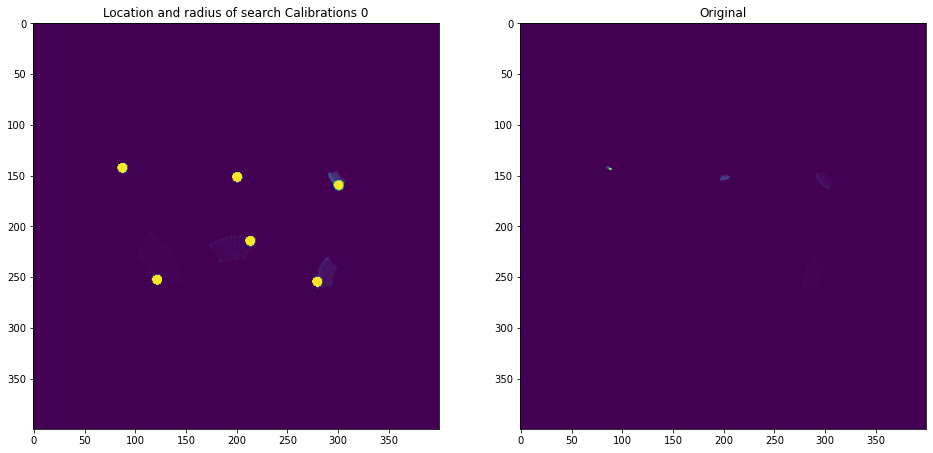

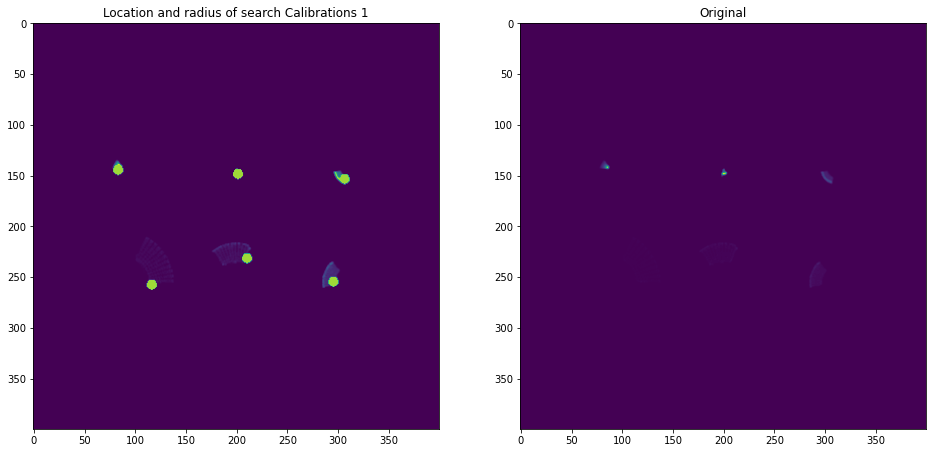

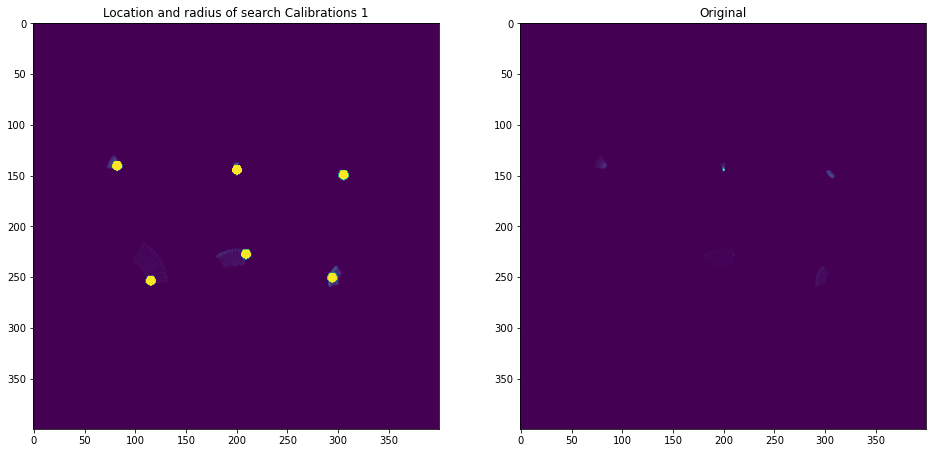

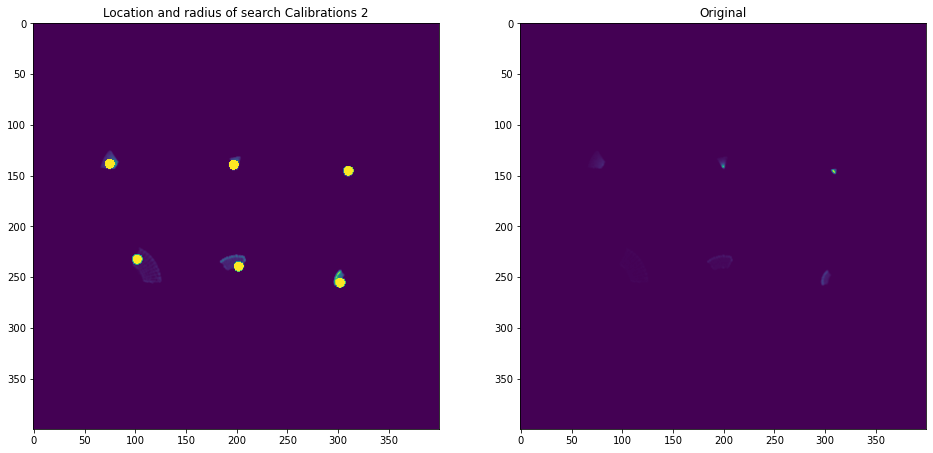

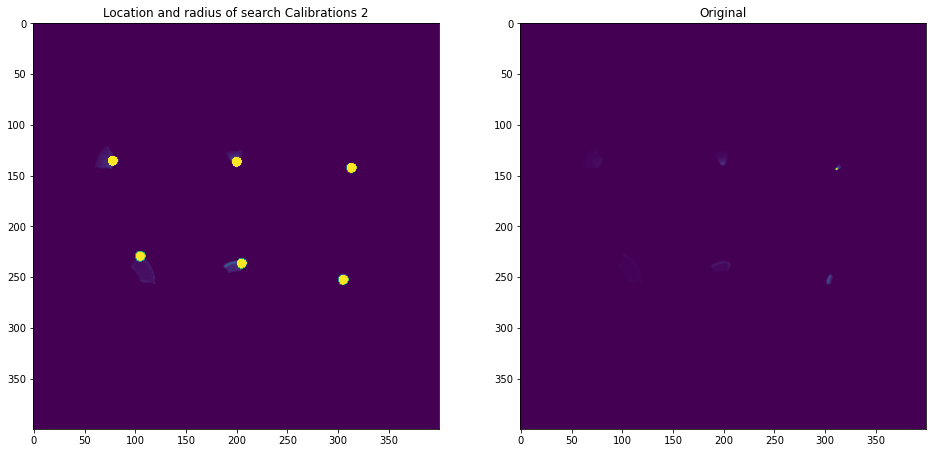

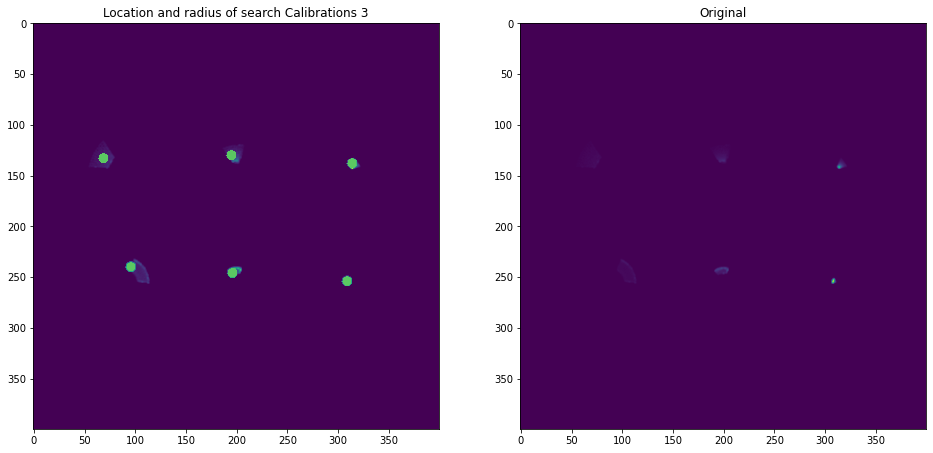

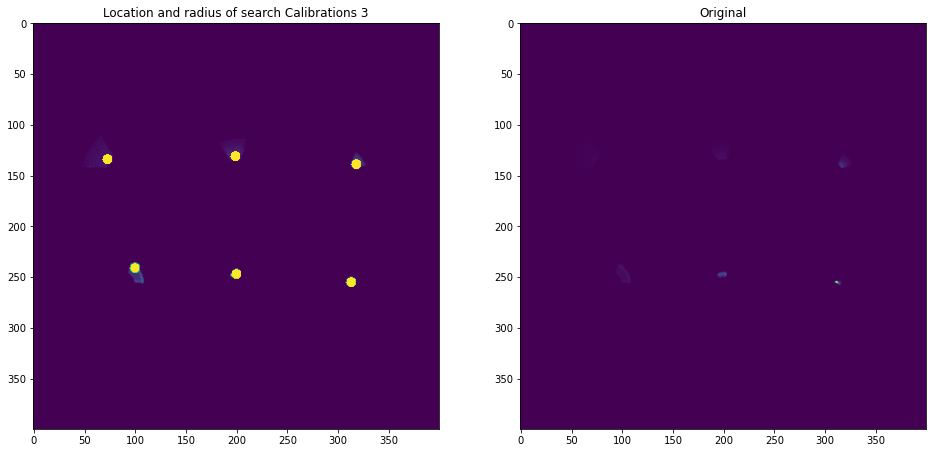

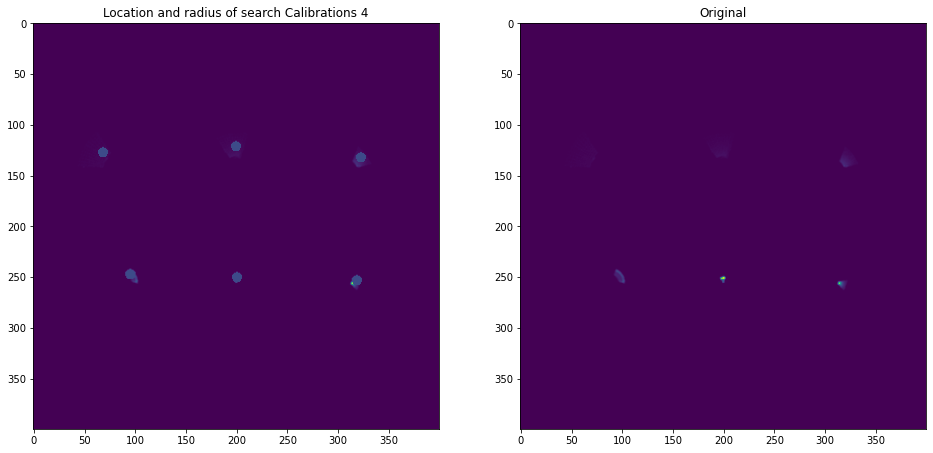

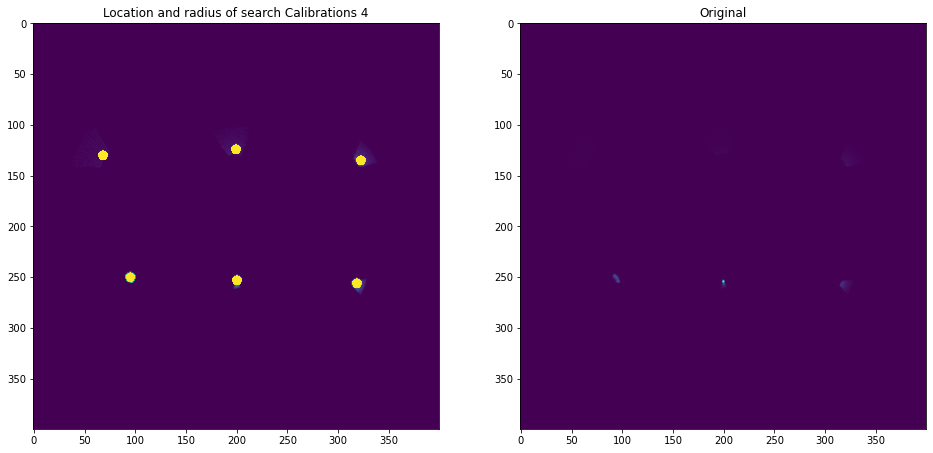

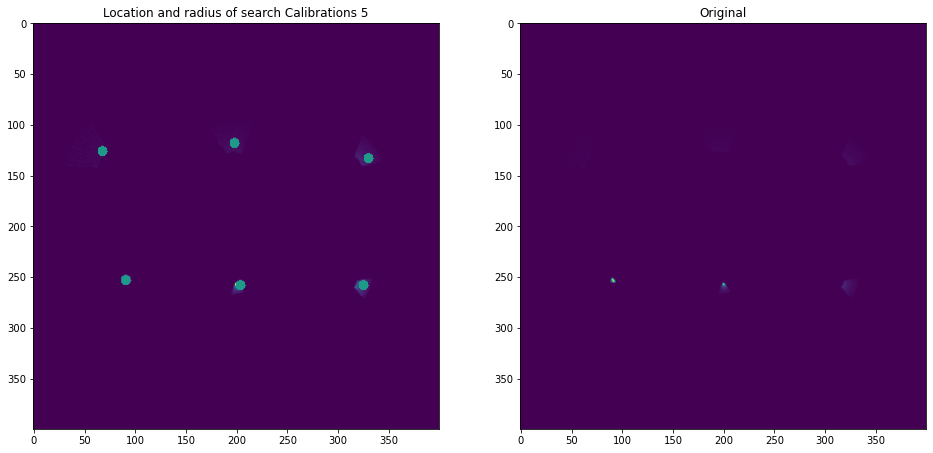

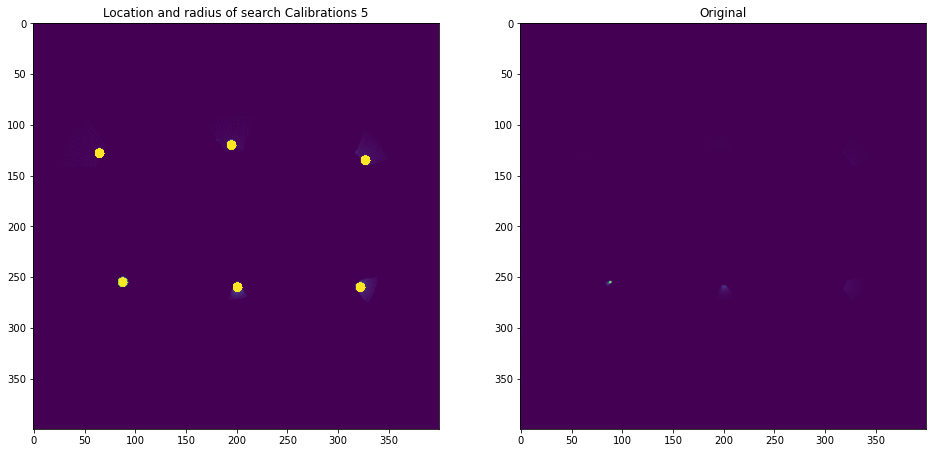

In [26]:
from scipy.ndimage.filters import gaussian_filter

# Parameters
sigma = 2 # For gaussian blur
connectivity = 2 # for detect peaks connectivity

#Calibrate data dictionary
Calib = get_Calibs('Calibrations')


####### FROM HERE START LOOP ######
files = ccd_helpers.get_img_files('Calibration')

for file in files:
    img = Image.open('Calibration/' + file)

    #imag data
    #img = Image.open('Calibrations/007.tiff')
    z_grid = np.array(img).astype('float')

    # Blurring
    z_grid_blur = gaussian_filter(z_grid, sigma)

    dimensions = z_grid_blur.shape 

    # With the length of the second dimension, create - 1 ~ 1 with dimensions[1] value 
    x = np.linspace(-1, 1, dimensions[1])

    # With the length of the first dimension, create - 1 ~ 1 with dimensions[0] value
    y = np.linspace(1, -1, dimensions[0])

    # create meshgrid as before
    x_grid, y_grid = np.meshgrid(x, y) 

    # Applying threshold
    threshold = np.max(z_grid_blur) * 0.1
    z_grid_blur[z_grid_blur<threshold] = 0

    # Detect the peaks positions
    peaks = get_2D_list(z_grid_blur, x_grid, y_grid)

    # Save the strongest X and Y values
    StrongX, StrongY = find_strongest_dude(peaks)

    # Find segment of strongest
    find_segment(StrongX, StrongY)

    # Put the segment, and x and y positions of the strongest particle detected here
    Calibp = [find_segment(StrongX, StrongY), StrongX, StrongY]

    # Remeber the number is the segement strongest is detected (0, 1, 2, 3, 4, 5)
    #print("Calib num is:" + str(Calibp[0]))

    # Plotting for reference
    fig = plt.figure(figsize=(16, 10))
    # setting values to rows and column variables
    rows = 1 
    columns = 2

    #peaks found within radius
    # Resets every iteration, so need to account for that
    found_peaks = psearch(peaks, 0.025)

    # A test grid to make sure I am searching the proper areas
    #z_grid[z_grid < threshold] = 0
    z_test = z_grid
    #z_test = z_grid_blur

    # Multiply by 5 to more clearly see the original locations
    z_test = np.multiply(z_test, 5)

    # Call the draw_radius ( clone of psearch) to draw the areas being searched
    z_test_after = draw_radius(z_test, 0.025)

    fig.add_subplot(rows, columns, 1) 
    # showing image
    plt.title("Location and radius of search Calibrations " + str(Calibp[0]))
    plt.imshow(z_test_after)
    
    
    z_grid = np.multiply(z_grid, 5)
    fig.add_subplot(rows, columns, 2) 
    # showing image
    plt.title("Original")
    plt.imshow(z_grid)